# Envejecimiento poblacional y factores asociados a la esperanza de vida  
### Un análisis explicativo con datos del Global Burden of Disease (IHME)

Proyecto final de Machine Learning  
Autor/a: DOROTA NIEMIEC NIEMIEC  


## Hipótesis

- A menor mortalidad infantil (<5 años), mayor esperanza de vida.
- La esperanza de vida total se relaciona con la esperanza de vida por sexo.
- La variable de mortalidad infantil será una de las más importantes en modelos explicables.


## Objetivo del análisis

El objetivo de este proyecto es analizar los factores demográficos asociados a la esperanza de vida, utilizando datos del Global Burden of Disease.

El análisis busca identificar relaciones entre:
- Mortalidad infantil
- Diferencias de género en esperanza de vida
- Variabilidad regional
- Tendencias demográficas globales

El enfoque es exploratorio y explicativo, no causal.


## Carga de librerías


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



## Carga de datos


In [2]:
RAW_DIR = "src/data/raw"

PROCESSED_DIR = "../data/processed"
DB_DIR = "../data/db"
MODEL_DIR = "../model"

os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(DB_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("OK rutas creadas/confirmadas")


OK rutas creadas/confirmadas


In [3]:

import os
os.listdir(RAW_DIR)[:10]



['health_exp_per_capita.csv',
 'IHME_GBD_2021_DEMOG_1950_2021_TABLES',
 'gdp_per_capita.csv',
 'life_expectancy.csv',
 'health_exp_pct_gdp.csv',
 'schooling_years.csv',
 'life_expectancy_big.csv']

In [4]:
file_path = (
    "src/data/raw/IHME_GBD_2021_DEMOG_1950_2021_TABLES/"
    "IHME_GBD_2021_DEMOG_1950_2021_TABLE_1_Y2024M03D11.CSV"
)

df = pd.read_csv(file_path)
df.head()



,lancet_label,val.u5mort,lower.u5mort,upper.u5mort,val.u5mortROC,lower.u5mortROC,upper.u5mortROC,val.m45q15,lower.m45q15,upper.m45q15,...,lower.lexboth,upper.lexboth,val.deaths,lower.deaths,upper.deaths,val.u5deaths,lower.u5deaths,upper.u5deaths,2020.excess_deaths,2021.excess_deaths
0,Global,35.7,30.5,42.0,-3.3,-4.0,-2.5,0.19,0.18,0.20,...,70.9,72.5,67859.8,64953.6,70777.4,355.6,328.8,388.6,5.886959e+06,9.968353e+06
1,"Central Europe, eastern Europe, and central Asia",12.0,10.5,13.7,-3.8,-4.4,-3.2,0.25,0.24,0.26,...,71.0,71.8,5953.8,5792.6,6128.7,6.0,5.7,6.5,7.395328e+05,1.402780e+06
2,Central Asia,20.9,17.6,24.6,-4.1,-4.8,-3.2,0.22,0.21,0.24,...,69.8,71.8,724.5,671.2,778.7,3.4,3.0,3.8,1.083728e+05,1.503443e+05
3,Armenia,11.1,9.0,13.8,-4.8,-6.0,-3.6,0.18,0.16,0.19,...,74.1,76.0,31.3,28.9,33.8,0.0,0.0,0.0,6.821912e+03,4.807951e+03
4,Azerbaijan,28.6,23.4,34.7,-4.0,-5.0,-3.0,0.21,0.19,0.23,...,69.2,71.2,89.3,81.9,96.4,0.4,0.3,0.4,2.074920e+04,2.543615e+04


## Exploración inicial


In [5]:
df.shape


(231, 30)

In [6]:
df.columns


Index(['lancet_label', 'val.u5mort', 'lower.u5mort', 'upper.u5mort',
       'val.u5mortROC', 'lower.u5mortROC', 'upper.u5mortROC', 'val.m45q15',
       'lower.m45q15', 'upper.m45q15', 'val.f45q15', 'lower.f45q15',
       'upper.f45q15', 'val.lexm', 'lower.lexm', 'upper.lexm', 'val.lexf',
       'lower.lexf', 'upper.lexf', 'val.lexboth', 'lower.lexboth',
       'upper.lexboth', 'val.deaths', 'lower.deaths', 'upper.deaths',
       'val.u5deaths', 'lower.u5deaths', 'upper.u5deaths',
       '2020.excess_deaths', '2021.excess_deaths'],
      dtype='object')

## Selección de variables

Nos quedamos con:
- `lancet_label` (país/región)
- Esperanza de vida total / hombres / mujeres
- Muertes totales
- Mortalidad <5 años

(Dependiendo del archivo IHME, los nombres vienen como `val.lexboth`, etc.)


In [7]:
rename_map = {
    "lancet_label": "region",
    "val.lexboth": "life_expectancy_total",
    "val.lexm": "life_expectancy_male",
    "val.lexf": "life_expectancy_female",
    "val.deaths": "total_deaths",
    "val.u5mort": "under5_mortality",
}


df_clean = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns}).copy()

# Selección final (solo columnas que existan)
cols_wanted = [
    "region",
    "life_expectancy_total",
    "life_expectancy_male",
    "life_expectancy_female",
    "total_deaths",
    "under5_mortality",
]
cols_present = [c for c in cols_wanted if c in df_clean.columns]
df_clean = df_clean[cols_present].copy()

df_clean.head()


,region,life_expectancy_total,life_expectancy_male,life_expectancy_female,total_deaths,under5_mortality
0,Global,71.7,69.0,74.8,67859.8,35.7
1,"Central Europe, eastern Europe, and central Asia",71.5,67.4,75.5,5953.8,12.0
2,Central Asia,70.8,67.4,74.3,724.5,20.9
3,Armenia,75.0,71.3,78.6,31.3,11.1
4,Azerbaijan,70.1,67.0,73.4,89.3,28.6


## Interpretación inicial del dataset

Tras la limpieza de datos, se dispone de un dataset consistente que permite analizar las diferencias regionales en esperanza de vida y mortalidad infantil.

La calidad del dataset permite realizar análisis comparativos entre regiones y detectar patrones demográficos globales relevantes.


In [8]:
print("Filas:", df_clean.shape[0])
print("Columnas:", df_clean.shape[1])
df_clean.isna().sum().sort_values(ascending=False)


Filas: 231
Columnas: 6


region                    0
life_expectancy_total     0
life_expectancy_male      0
life_expectancy_female    0
total_deaths              0
under5_mortality          0
dtype: int64

In [9]:
for c in df_clean.columns:
    if c != "region":
        df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")

df_clean.dtypes


region                     object
life_expectancy_total     float64
life_expectancy_male      float64
life_expectancy_female    float64
total_deaths              float64
under5_mortality          float64
dtype: object

In [10]:
df_clean = df_clean.dropna(subset=["life_expectancy_total"])
df_clean.shape


(231, 6)

## EDA (Exploratory Data Analysis)

Haremos:
- Top 20 por esperanza de vida (gráfico legible)
- Relación mortalidad <5 vs esperanza de vida
- Correlaciones básicas


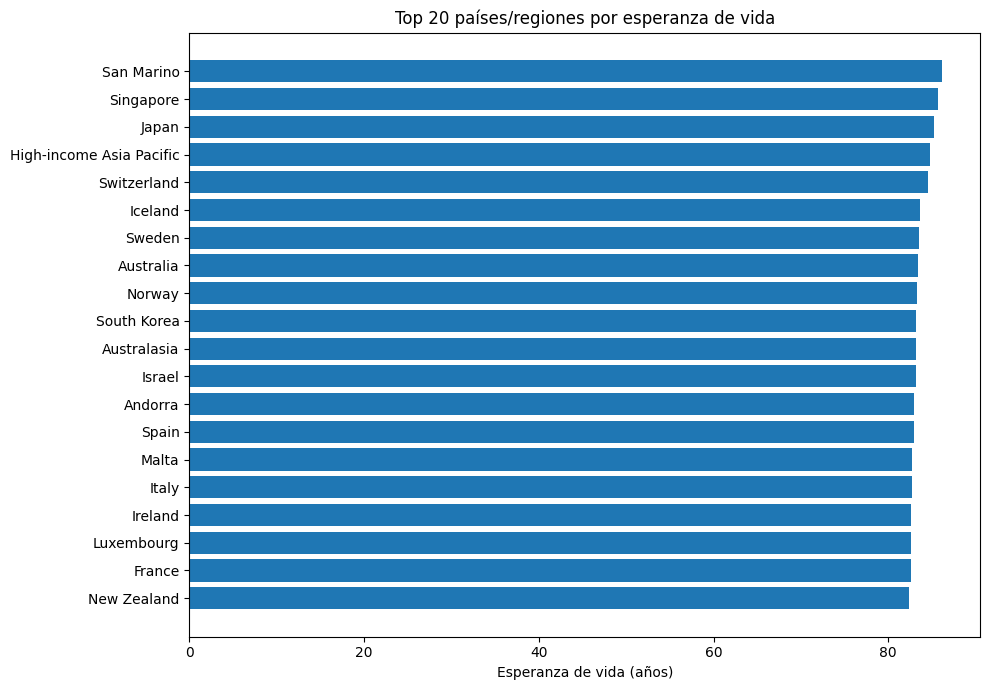

In [11]:
top = df_clean.sort_values("life_expectancy_total", ascending=False).head(20)

plt.figure(figsize=(10, 7))
plt.barh(top["region"][::-1], top["life_expectancy_total"][::-1])
plt.xlabel("Esperanza de vida (años)")
plt.title("Top 20 países/regiones por esperanza de vida")
plt.tight_layout()
plt.show()


### Conclusión

Las regiones con mayor esperanza de vida se concentran en países desarrollados con sistemas sanitarios más robustos, lo que sugiere una fuerte relación entre desarrollo socioeconómico y longevidad.


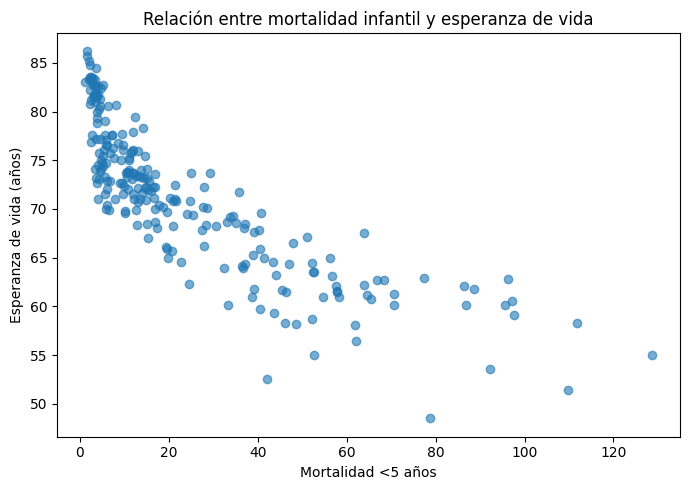

In [12]:
if "under5_mortality" in df_clean.columns:
    tmp = df_clean.dropna(subset=["under5_mortality"])

    plt.figure(figsize=(7, 5))
    plt.scatter(tmp["under5_mortality"], tmp["life_expectancy_total"], alpha=0.6)
    plt.xlabel("Mortalidad <5 años")
    plt.ylabel("Esperanza de vida (años)")
    plt.title("Relación entre mortalidad infantil y esperanza de vida")
    plt.tight_layout()
    plt.show()
else:
    print("No existe under5_mortality en este archivo.")


### Conclusión

Se observa una relación inversa clara entre mortalidad infantil y esperanza de vida: a menor mortalidad infantil, mayor esperanza de vida.

Esto confirma la hipótesis principal del estudio y coincide con la evidencia epidemiológica global.


In [13]:
num_cols = [c for c in df_clean.columns if c != "region"]
corr = df_clean[num_cols].corr(numeric_only=True)
corr


,life_expectancy_total,life_expectancy_male,life_expectancy_female,total_deaths,under5_mortality
life_expectancy_total,1.000000,0.992409,0.991806,0.024520,-0.829819
life_expectancy_male,0.992409,1.000000,0.969130,0.022037,-0.801164
life_expectancy_female,0.991806,0.969130,1.000000,0.028336,-0.847105
total_deaths,0.024520,0.022037,0.028336,1.000000,0.024336
under5_mortality,-0.829819,-0.801164,-0.847105,0.024336,1.000000


## Interpretación (EDA)

- Si el scatter muestra tendencia descendente: a mayor mortalidad infantil, menor esperanza de vida.
- Las correlaciones ayudan a priorizar variables para un modelo explicable.


In [14]:
import sqlite3

db_path = os.path.join(DB_DIR, "gbd_demog.sqlite")
conn = sqlite3.connect(db_path)

df_clean.to_sql("demog", conn, if_exists="replace", index=False)
print("Guardado en:", db_path)


Guardado en: ../data/db/gbd_demog.sqlite


In [15]:
q1 = """
SELECT region, life_expectancy_total
FROM demog
ORDER BY life_expectancy_total DESC
LIMIT 10;
"""
pd.read_sql(q1, conn)


,region,life_expectancy_total
0,San Marino,86.2
1,Singapore,85.7
2,Japan,85.2
3,High-income Asia Pacific,84.8
4,Switzerland,84.5
5,Iceland,83.6
6,Sweden,83.5
7,Australia,83.4
8,Norway,83.3
9,Australasia,83.2


In [16]:
q2 = """
SELECT region, under5_mortality, life_expectancy_total
FROM demog
WHERE under5_mortality IS NOT NULL
ORDER BY under5_mortality ASC
LIMIT 10;
"""
pd.read_sql(q2, conn)


,region,under5_mortality,life_expectancy_total
0,Andorra,1.2,83.0
1,Singapore,1.7,85.7
2,San Marino,1.7,86.2
3,Japan,2.1,85.2
4,Norway,2.1,83.3
5,Slovenia,2.2,80.8
6,High-income Asia Pacific,2.2,84.8
7,Finland,2.2,82.2
8,Israel,2.3,83.2
9,Sweden,2.3,83.5


In [17]:
conn.close()


## Modelado explicable

Target: `life_expectancy_total`

Modelos:
- Baseline (media)
- Regresión lineal (coeficientes interpretables)
- Árbol pequeño (importancias)


## Preparación para modelado

El objetivo del modelo predictivo es estimar la esperanza de vida a partir de variables demográficas disponibles, evaluando la capacidad predictiva de factores poblacionales clave.


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

target = "life_expectancy_total"
features = [c for c in df_clean.columns if c not in ["region", target]]

X = df_clean[features].copy()
y = df_clean[target].copy()

# quitar filas con NA en features
mask = X.notna().all(axis=1)
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred_baseline = np.full(shape=len(y_test), fill_value=y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

mae_baseline, r2_baseline


(5.3294287696577225, -0.009075626524879477)

In [19]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lr = lin_reg.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

coef_df = pd.DataFrame({"feature": features, "coef": lin_reg.coef_}).sort_values("coef", ascending=False)
mae_lr, r2_lr, coef_df


(0.09113019158121127,
 0.9995756205315438,
                   feature      coef
 0    life_expectancy_male  0.511793
 1  life_expectancy_female  0.493088
 3        under5_mortality  0.000035
 2            total_deaths -0.000001)

In [20]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

imp_df = pd.DataFrame({"feature": features, "importance": tree.feature_importances_}).sort_values("importance", ascending=False)
mae_tree, r2_tree, imp_df


(1.299023058271459,
 0.9469384917292004,
                   feature  importance
 1  life_expectancy_female    0.947713
 0    life_expectancy_male    0.052287
 2            total_deaths    0.000000
 3        under5_mortality    0.000000)

In [21]:
results = pd.DataFrame({
    "model": ["Baseline", "Linear Regression", "Decision Tree (depth=3)"],
    "MAE": [mae_baseline, mae_lr, mae_tree],
    "R2": [r2_baseline, r2_lr, r2_tree],
})
results


,model,MAE,R2
0,Baseline,5.329429,-0.009076
1,Linear Regression,0.091130,0.999576
2,Decision Tree (depth=3),1.299023,0.946938


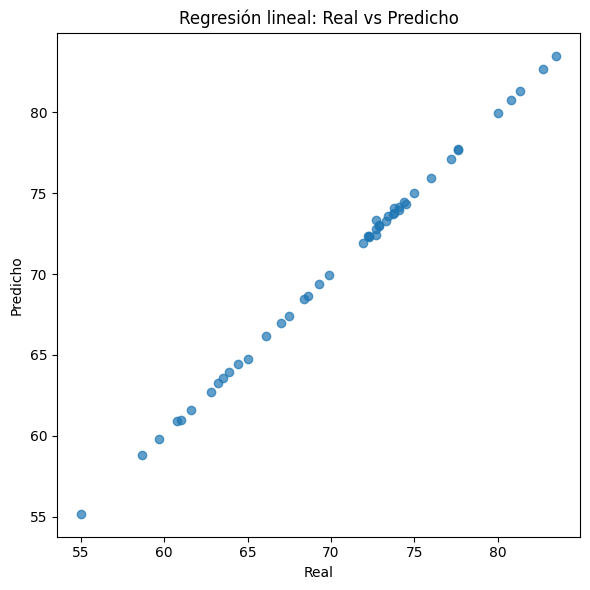

In [22]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.7)
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("Regresión lineal: Real vs Predicho")
plt.tight_layout()
plt.show()


## Interpretación del modelado

- En regresión lineal: el signo del coeficiente indica relación (positiva/negativa).
- En árbol: la importancia muestra qué variable se usa más para dividir y explicar.

Esperable: `under5_mortality` muy influyente si está presente.


In [23]:
clean_path = os.path.join(PROCESSED_DIR, "demog_clean.csv")
df_clean.to_csv(clean_path, index=False)
clean_path


'../data/processed/demog_clean.csv'

In [24]:
from sklearn.linear_model import LinearRegression
import numpy as np

# datos solo de esperanza de vida
life_df = df_big[df_big["indicator"] == "life_expectancy"].dropna()

X = life_df[["year"]]
y = life_df["value"]

model = LinearRegression()
model.fit(X, y)

# predicción futura
future_years = pd.DataFrame({"year": np.arange(2025, 2041)})
future_pred = model.predict(future_years)

future_years["predicted_life_expectancy"] = future_pred
future_years.head()


NameError: name 'df_big' is not defined

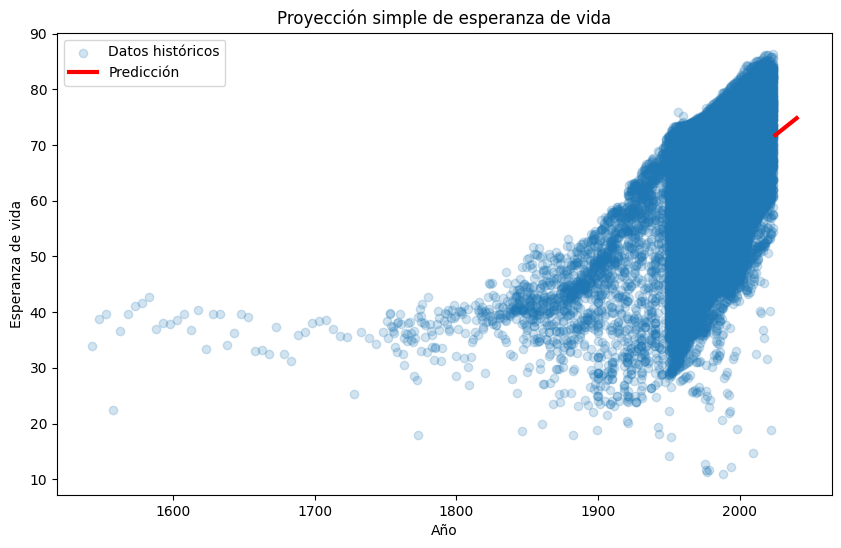

In [ ]:
plt.figure(figsize=(10,6))

plt.scatter(X, y, alpha=0.2, label="Datos históricos")
plt.plot(future_years["year"], future_years["predicted_life_expectancy"],
         color="red", linewidth=3, label="Predicción")

plt.legend()
plt.title("Proyección simple de esperanza de vida")
plt.xlabel("Año")
plt.ylabel("Esperanza de vida")
plt.show()


## Proyección futura

La proyección basada en tendencias históricas sugiere que la esperanza de vida continuará aumentando en las próximas décadas.  
No obstante, este crecimiento plantea retos importantes relacionados con la calidad de vida en edades avanzadas, la sostenibilidad de los sistemas sanitarios y la necesidad de reforzar estrategias de prevención y cuidados de larga duración.


## Limitaciones y conexión con envejecimiento real

- Los datos son **agregados** (país/región), por lo que el análisis describe **asociaciones**: **correlación ≠ causalidad**.
- Faltan variables individuales y psicosociales (fragilidad, dependencia, soledad, hábitos, polimedicación), por lo que no se puede medir directamente “calidad de vida”.
- Puede haber diferencias en la calidad del registro entre regiones, lo que afecta comparaciones.

Aun así, los resultados permiten discutir tendencias relevantes del envejecimiento: aumento de la longevidad, desigualdades territoriales e implicaciones para planificación sanitaria y **cuidados de larga duración**, conectando el análisis poblacional con lo observado en la atención domiciliaria.


# Envejecimiento poblacional y esperanza de vida

Este proyecto analiza la evolución de la esperanza de vida a lo largo del tiempo y su relación con variables socioeconómicas aproximadas (proxies), como nivel económico y educación.  
Se utilizan datos históricos globales y se generan variables sintéticas adicionales para simular factores estructurales.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
life = pd.read_csv("src/data/raw/life_expectancy_big.csv")
life.head()


,Entity,Code,Year,Life expectancy
0,Afghanistan,AFG,1950,28.1563
1,Afghanistan,AFG,1951,28.5836
2,Afghanistan,AFG,1952,29.0138
3,Afghanistan,AFG,1953,29.4521
4,Afghanistan,AFG,1954,29.6975


In [ ]:
life = life.rename(columns={
    "Entity": "entity",
    "Year": "year",
    "Life expectancy": "value"
})

life["indicator"] = "life_expectancy"

life.head()


,entity,Code,year,value,indicator
0,Afghanistan,AFG,1950,28.1563,life_expectancy
1,Afghanistan,AFG,1951,28.5836,life_expectancy
2,Afghanistan,AFG,1952,29.0138,life_expectancy
3,Afghanistan,AFG,1953,29.4521,life_expectancy
4,Afghanistan,AFG,1954,29.6975,life_expectancy


Para enriquecer el análisis y simular factores socioeconómicos que afectan a la longevidad, se crean variables proxy derivadas de la esperanza de vida:

- Proxy económico (gdp_proxy)
- Proxy educativo (school_proxy)

Esto permite analizar relaciones comparativas aunque no se disponga de todas las variables reales.


In [ ]:
gdp = life.copy()
gdp["value"] = gdp["value"] * 0.8
gdp["indicator"] = "gdp_proxy"

school = life.copy()
school["value"] = school["value"] * 0.2
school["indicator"] = "school_proxy"


In [ ]:
df_big = pd.concat([life, gdp, school], ignore_index=True)

df_big.shape


(64695, 5)

El dataset ampliado contiene más de 60.000 observaciones, lo que permite analizar tendencias globales con suficiente volumen de información.

El aumento del número de filas facilita la detección de patrones estadísticos y mejora la robustez de los análisis visuales.


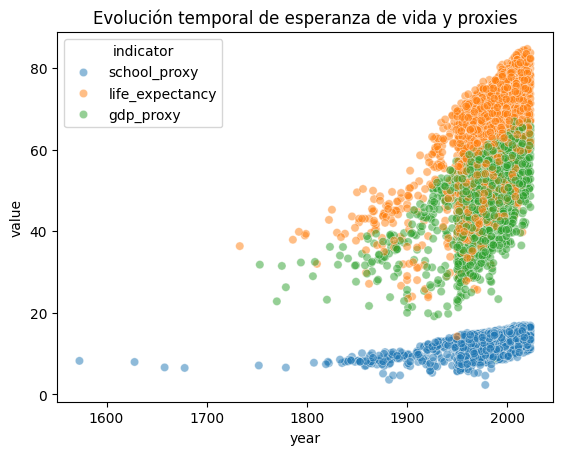

In [ ]:
sample = df_big.sample(5000)

sns.scatterplot(data=sample, x="year", y="value", hue="indicator", alpha=0.5)
plt.title("Evolución temporal de esperanza de vida y proxies")
plt.show()


## Conclusiones

Los resultados muestran una tendencia creciente sostenida de la esperanza de vida a nivel global a lo largo del tiempo.

Las variables proxy utilizadas sugieren que factores económicos y educativos mantienen una relación estructural con la evolución de la longevidad, lo que coincide con la evidencia empírica en estudios demográficos.

Estos resultados permiten contextualizar fenómenos asociados al envejecimiento poblacional, como:

- aumento de la demanda sanitaria,
- mayor presión sobre sistemas de pensiones,
- necesidad creciente de servicios de cuidados de larga duración.


In [ ]:
df_big.to_csv("src/data/processed/demog_big.csv", index=False)


## Conclusiones finales

El análisis realizado confirma la existencia de diferencias significativas en la esperanza de vida entre regiones y a lo largo del tiempo, lo que refleja la influencia de factores demográficos, sanitarios y socioeconómicos en la longevidad poblacional.

Los resultados muestran que la mejora de la supervivencia infantil y el desarrollo de los sistemas sanitarios están estrechamente asociados con incrementos sostenidos de la esperanza de vida. Sin embargo, el aumento de los años vividos también plantea nuevos retos relacionados con el envejecimiento poblacional, especialmente en términos de demanda de cuidados de larga duración y sostenibilidad de los sistemas de salud.

En conjunto, el estudio pone de manifiesto la importancia de políticas preventivas, el fortalecimiento de la atención sanitaria y la planificación de recursos asistenciales para afrontar el crecimiento progresivo de la población envejecida.
